In [17]:
import time
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams['font.family'] = ['sans-serif']
import seaborn as sns
import numpy as np

import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns',100)#显示最大列数

# 读取数据

In [18]:
data_path = './data/'
train_data = pd.read_csv(data_path + 'train_dataset.csv')
test_data = pd.read_csv(data_path + 'test_dataset.csv')
sample_sub = pd.read_csv(data_path + 'submit_example.csv')

# 查看特征名称

In [19]:
train_data.columns

Index(['用户编码', '用户实名制是否通过核实', '用户年龄', '是否大学生客户', '是否黑名单客户', '是否4G不健康客户',
       '用户网龄（月）', '用户最近一次缴费距今时长（月）', '缴费用户最近一次缴费金额（元）', '用户近6个月平均消费值（元）',
       '用户账单当月总费用（元）', '用户当月账户余额（元）', '缴费用户当前是否欠费缴费', '用户话费敏感度', '当月通话交往圈人数',
       '是否经常逛商场的人', '近三个月月均商场出现次数', '当月是否逛过福州仓山万达', '当月是否到过福州山姆会员店', '当月是否看电影',
       '当月是否景点游览', '当月是否体育场馆消费', '当月网购类应用使用次数', '当月物流快递类应用使用次数',
       '当月金融理财类应用使用总次数', '当月视频播放类应用使用次数', '当月飞机类应用使用次数', '当月火车类应用使用次数',
       '当月旅游资讯类应用使用次数', '信用分'],
      dtype='object')

# 查看是否存在缺失值，以及数据量

In [20]:
train_data.info()
# 有些数据已经被主办方处理过，有些缺失值被用0来填充，导致一些特定的数据难以分辨是空值还是0值，
# 还有一些数据被主办方取整和分箱了，所以是不存在缺省值的。

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   用户编码             50000 non-null  object 
 1   用户实名制是否通过核实      50000 non-null  int64  
 2   用户年龄             50000 non-null  int64  
 3   是否大学生客户          50000 non-null  int64  
 4   是否黑名单客户          50000 non-null  int64  
 5   是否4G不健康客户        50000 non-null  int64  
 6   用户网龄（月）          50000 non-null  int64  
 7   用户最近一次缴费距今时长（月）  50000 non-null  int64  
 8   缴费用户最近一次缴费金额（元）  50000 non-null  float64
 9   用户近6个月平均消费值（元）   50000 non-null  float64
 10  用户账单当月总费用（元）     50000 non-null  float64
 11  用户当月账户余额（元）      50000 non-null  int64  
 12  缴费用户当前是否欠费缴费     50000 non-null  int64  
 13  用户话费敏感度          50000 non-null  int64  
 14  当月通话交往圈人数        50000 non-null  int64  
 15  是否经常逛商场的人        50000 non-null  int64  
 16  近三个月月均商场出现次数     50000 non-null  int64  
 17  当月是否逛过福州仓山万达

# 判断各列和信用分的相关性

Text(0.5, 1.0, 'Correlation coeficient of the variables')

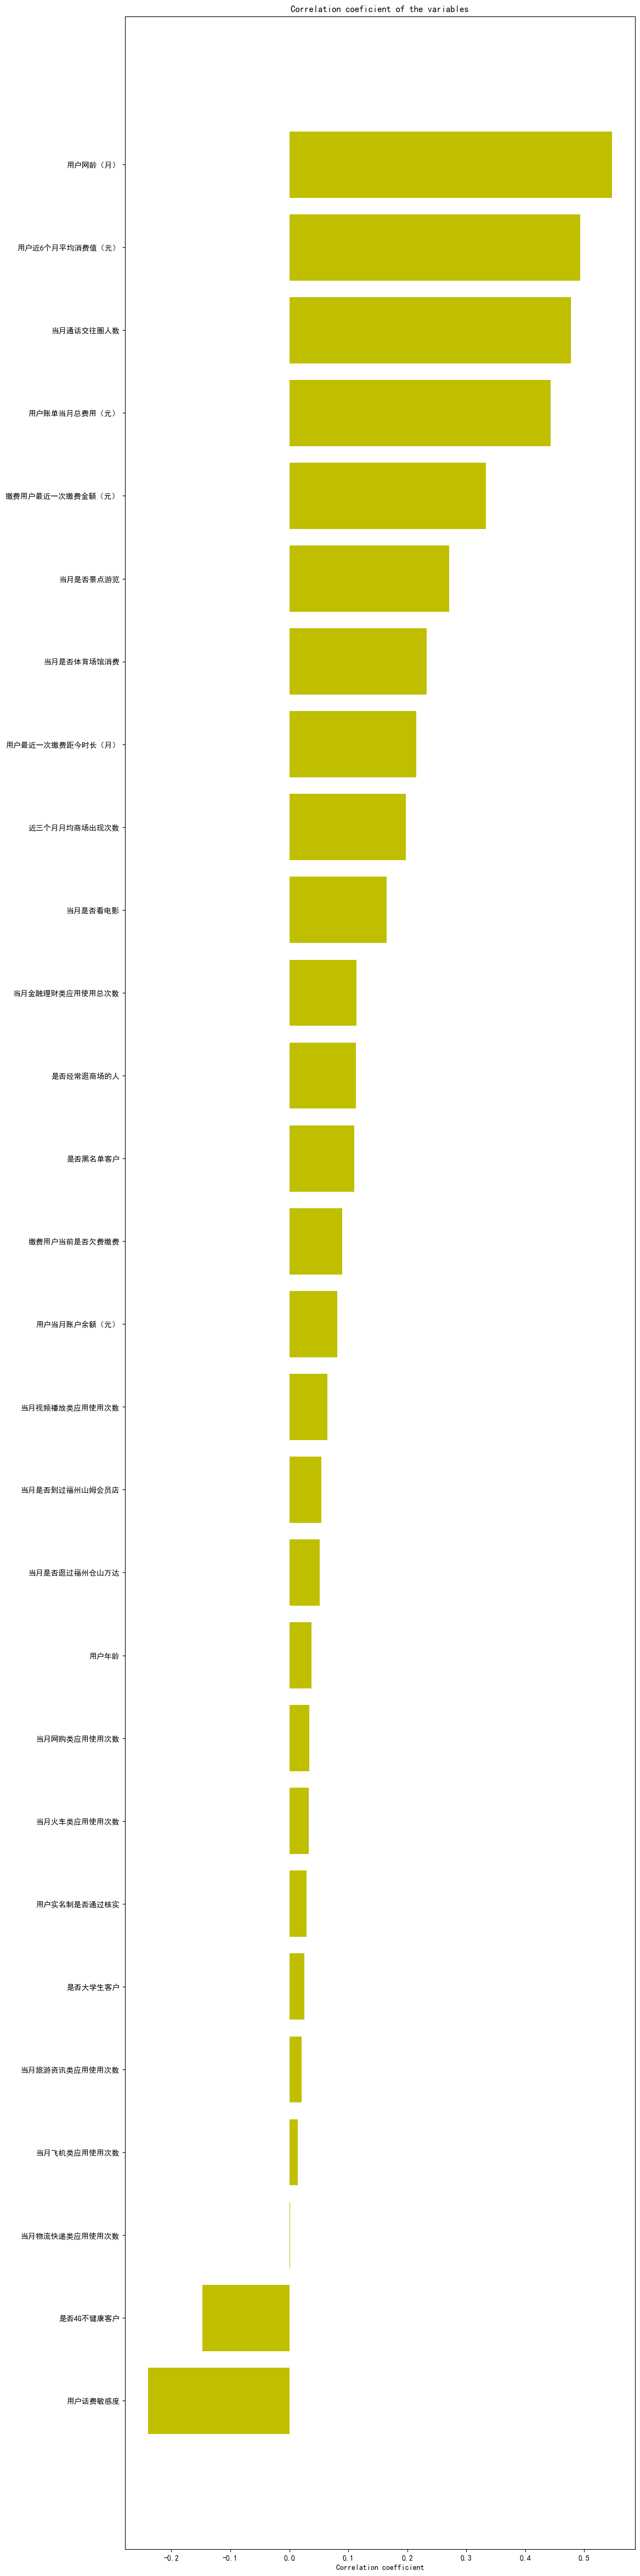

In [21]:

x_cols=[col for col in train_data.columns if col not in ['信用分'] and train_data[col].dtype!='object']
labels=[]
values=[]

#判断各列和信用分的相关性
# 相关性系数:np.corrcoef
# 循环遍历每个特征，将每个特征的全部值与信用分别形成矩阵进行计算。
# 相关系数矩阵R与协方差矩阵C之间的关系为：Rij=Cij/根号下Cii*Cjj -1~1
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_data[col].values,train_data['信用分'].values)[0,1])
    
corr_df=pd.DataFrame({'col_labels':labels,'corr_values':values})
corr_df=corr_df.sort_values(by='corr_values')

ind=np.arange(len(labels))
width=0.5
fig,ax=plt.subplots(figsize=(12,60))
rects=ax.barh(ind,np.array(corr_df.corr_values.values),color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values,rotation='horizontal')
ax.set_xlabel('Correlation coefficient')
ax.set_title('Correlation coeficient of the variables')


# 密度曲线

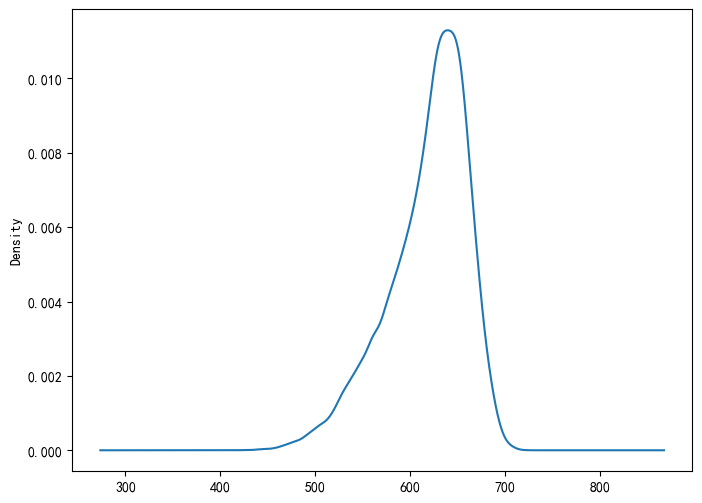

In [22]:
#密度曲线
def plot_kde(data):
    plt.figure(figsize=(8,6))
    data.plot(kind='kde')

def plot_his(data):
    plt.figure(figsize=(8,6))
    sns.distplot(data.values,bins=50,kde=False)

plot_kde(train_data['信用分'])

# 特征工程

In [23]:
##top up amount, 充值金额是整数，和小数，应该对应不同的充值途径？
def produce_offline_feature(train_data):
    train_data['不同充值途径']=0
    train_data['不同充值途径'][(train_data['缴费用户最近一次缴费金额（元）']%10==0)&train_data['缴费用户最近一次缴费金额（元）']!=0]=1
    return train_data

train_data=produce_offline_feature(train_data)
print(train_data['不同充值途径'])
test_data=produce_offline_feature(test_data)
print(test_data['不同充值途径'])

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: 不同充值途径, Length: 50000, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    1
49997    0
49998    0
49999    0
Name: 不同充值途径, Length: 50000, dtype: int64


C:\Users\86182\AppData\Local\Temp\ipykernel_1432\2267108374.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['不同充值途径'][(train_data['缴费用户最近一次缴费金额（元）']%10==0)&train_data['缴费用户最近一次缴费金额（元）']!=0]=1
C:\Users\86182\AppData\Local\Temp\ipykernel_1432\2267108374.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['不同充值途径'][(train_data['缴费用户最近一次缴费金额（元）']%10==0)&train_data['缴费用户最近一次缴费金额（元）']!=0]=1


In [24]:
##看importance，当月话费 和最近半年平均话费都很高，算一下当月/半年 -->稳定性
def produce_fee_rate(train_data):
    train_data['当前费用稳定性']=train_data['用户账单当月总费用（元）']/(train_data['用户近6个月平均消费值（元）']+1)
    
    ##当月话费/当月账户余额
    train_data['用户余额比例']=train_data['用户账单当月总费用（元）']/(train_data['用户当月账户余额（元）']+1)
    return train_data

train_data=produce_fee_rate(train_data)
print(train_data['当前费用稳定性'],train_data['用户余额比例'])
test_data=produce_fee_rate(test_data)
print(test_data['当前费用稳定性'],test_data['用户余额比例'])

0        0.965668
1        0.940498
2        1.086406
3        1.781632
4        1.046958
           ...   
49995    0.716235
49996    0.991409
49997    0.996492
49998    0.868621
49999    0.785027
Name: 当前费用稳定性, Length: 50000, dtype: float64 0        0.879558
1        1.307207
2        1.692958
3        1.839780
4        1.246914
           ...   
49995    1.029412
49996    2.556863
49997    0.437009
49998    0.288288
49999    1.389109
Name: 用户余额比例, Length: 50000, dtype: float64
0        0.714306
1        2.452124
2        1.051503
3        0.967042
4        0.973501
           ...   
49995    0.978723
49996    0.842701
49997    1.057471
49998    1.350503
49999    1.021604
Name: 当前费用稳定性, Length: 50000, dtype: float64 0        0.263770
1        1.621905
2        1.413967
3        1.009050
4        2.031373
           ...   
49995    0.120735
49996    2.559756
49997    1.281967
49998    4.095238
49999    1.487805
Name: 用户余额比例, Length: 50000, dtype: float64


In [25]:
#获取特征
def get_features(data):
    data.loc[data['用户年龄']==0,'用户年龄']=data['用户年龄'].mode()
    data['缴费金额是否能覆盖当月账单']=data['缴费用户最近一次缴费金额（元）']-data['用户账单当月总费用（元）']
    data['最近一次缴费是否超过平均消费额']=data['缴费用户最近一次缴费金额（元）']-data['用户近6个月平均消费值（元）']
    data['当月账单是否超过平均消费额']=data['用户账单当月总费用（元）']-data['用户近6个月平均消费值（元）']
    
    #映射年龄
    def map_age(x):
        if x<=18:
            return 1
        elif x<=30:
            return 2
        elif x<=35:
            return 3
        elif x<=45:
            return 4
        else:
            return 5
    data['是否大学生_黑名单']=data['是否大学生客户']+data['是否黑名单客户']
    data['是否去过高档商场']=data['当月是否到过福州山姆会员店']+data['当月是否逛过福州仓山万达']
    data['是否去过高档商场']=data['是否去过高档商场'].map(lambda x:1 if x>=1 else 0)
    data['是否_商场_电影']=data['是否去过高档商场']*data['当月是否看电影']
    data['是否_商场_体育馆']=data['是否去过高档商场']*data['当月是否体育场馆消费']
    data['是否_商场_旅游']=data['是否去过高档商场']*data['当月是否景点游览']
    data['是否_电影_体育馆']=data['当月是否看电影']*data['当月是否体育场馆消费']
    data['是否_电影_旅游']=data['当月是否看电影']*data['当月是否景点游览']
    data['是否_旅游_体育馆']=data['当月是否景点游览']*data['当月是否体育场馆消费']
    
    data['是否_商场_旅游_体育馆']=data['是否去过高档商场']*data['当月是否景点游览']*data['当月是否体育场馆消费']
    data['是否_商场_电影_体育馆']=data['是否去过高档商场']*data['当月是否看电影']*data['当月是否体育场馆消费']
    data['是否_商场_电影_旅游']=data['是否去过高档商场']*data['当月是否看电影']*data['当月是否景点游览']
    data['是否_体育馆_电影_旅游']=data['当月是否体育场馆消费']*data['当月是否看电影']*data['当月是否景点游览']
    
    data['是否_商场_体育馆_电影_旅游']=data['是否去过高档商场']*data['当月是否体育场馆消费']*data['当月是否看电影']*data['当月是否景点游览']
    
    discretize_features=['交通类应用使用次数','当月物流快递类应用使用次数','当月飞机类应用使用次数','当月火车类应用使用次数','当月旅游资讯类应用使用次数']
    data['交通类应用使用次数']=data['当月飞机类应用使用次数']+data['当月火车类应用使用次数']
    
    data['6个月平均占比总费用']=data['用户近6个月平均消费值（元）']/data['用户账单当月总费用（元）']+1
    
    
    def map_discretize(x):
        if x==0:
            return 0
        elif x<=5:
            return 1
        elif x<=15:
            return 2
        elif x<=50:
            return 3
        elif x<=100:
            return 4
        else:
            return 5
        
    for col in discretize_features[:]:
        data[col]=data[col].map(lambda x:map_discretize(x))
    
    return data

train_data=get_features(train_data)
test_data=get_features(test_data)


In [26]:
def base_process(data):
    transform_value_feature=['用户年龄','用户网龄（月）','当月通话交往圈人数','近三个月月均商场出现次数','当月网购类应用使用次数','当月物流快递类应用使用次数'
                            ,'当月金融理财类应用使用总次数','当月视频播放类应用使用次数','当月飞机类应用使用次数','当月火车类应用使用次数','当月旅游资讯类应用使用次数']
    user_fea=['缴费用户最近一次缴费金额（元）','用户近6个月平均消费值（元）','用户账单当月总费用（元）','用户当月账户余额（元）']
    log_features=['当月网购类应用使用次数','当月金融理财类应用使用总次数','当月物流快递类应用使用次数','当月视频播放类应用使用次数']
    
    #处理离散点
    for col in transform_value_feature+user_fea+log_features:
        #取出最高99.9%值
        ulimit=np.percentile(train_data[col].values,99.9)
        #取出最低0.1%值
        llimit=np.percentile(train_data[col].values,0.1)
        train_data.loc[train_data[col]>ulimit,col]=ulimit
        train_data.loc[train_data[col]<llimit,col]=llimit
        
    for col in user_fea+log_features:
        data[col]=data[col].map(lambda x:np.log1p(x))
    
    return data

train_data=base_process(train_data)
test_data=base_process(test_data)

# 特征重要度显示函数

In [27]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

# 训练及预测

In [28]:
#para
params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mae',
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'num_leaves': 31,
    'verbose': -1,
    'max_depth': -1,
    'reg_alpha':2.2,
    'reg_lambda':1.4,
    'nthread': 8
}

In [29]:
from sklearn.model_selection import KFold
cv_pred_all = 0
en_amount = 3

oof_lgb1=np.zeros(len(train_data))#存放训练集的预测结果
prediction_lgb1=np.zeros(len(test_data))#存放测试集的预测结果

for seed in range(en_amount):
    NFOLDS = 5
    train_label = train_data['信用分']
    #五折
    kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=seed)
    kf = kfold.split(train_data, train_label)

    train_data_use = train_data.drop(['用户编码','信用分'], axis=1)
    test_data_use = test_data.drop(['用户编码'], axis=1)


    cv_pred = np.zeros(test_data.shape[0])
    valid_best_l2_all = 0

    feature_importance_df = pd.DataFrame()
    count = 0
    for i, (train_fold, validate) in enumerate(kf):
        print('fold: ',i, ' training')
        X_train, X_validate, label_train, label_validate = \
        train_data_use.iloc[train_fold, :], train_data_use.iloc[validate, :], \
        train_label[train_fold], train_label[validate]
        dtrain = lgb.Dataset(X_train, label_train)#80%的训练集用于训练
        dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain)#20%的训练集做验证集

        bst = lgb.train(params, dtrain, num_boost_round=10000, valid_sets=dvalid, verbose_eval=-1,early_stopping_rounds=250)#训练过程
        cv_pred += bst.predict(test_data_use, num_iteration=bst.best_iteration)#对验证集得到预测结果
        valid_best_l2_all += bst.best_score['valid_0']['l1']
        oof_lgb1[validate]=bst.predict(X_validate,num_iteration=bst.best_iteration)
        prediction_lgb1+=bst.predict(test_data_use,num_iteration=bst.best_iteration)/kfold.n_splits#对测试集5次取平均值

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = list(X_train.columns)
        fold_importance_df["importance"] = bst.feature_importance(importance_type='split', iteration=bst.best_iteration)
        fold_importance_df["fold"] = count + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        count += 1

    cv_pred /= NFOLDS
    valid_best_l2_all /= NFOLDS
    
    cv_pred_all += cv_pred
cv_pred_all /= en_amount
prediction_lgb1/=en_amount
print('cv score for valid is: ', 1/(1+valid_best_l2_all))


fold:  0  training
Training until validation scores don't improve for 250 rounds


D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[3012]	valid_0's l1: 14.76
fold:  1  training
Training until validation scores don't improve for 250 rounds


D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[3284]	valid_0's l1: 14.7261
fold:  2  training
Training until validation scores don't improve for 250 rounds


D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[2618]	valid_0's l1: 14.5491
fold:  3  training
Training until validation scores don't improve for 250 rounds


D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[3481]	valid_0's l1: 14.5451
fold:  4  training
Training until validation scores don't improve for 250 rounds


D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[4015]	valid_0's l1: 14.7386
fold:  0  training
Training until validation scores don't improve for 250 rounds


D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[3198]	valid_0's l1: 14.6213
fold:  1  training
Training until validation scores don't improve for 250 rounds


D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[2715]	valid_0's l1: 14.6579
fold:  2  training
Training until validation scores don't improve for 250 rounds


D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[4065]	valid_0's l1: 14.5646
fold:  3  training
Training until validation scores don't improve for 250 rounds


D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[3235]	valid_0's l1: 14.7352
fold:  4  training
Training until validation scores don't improve for 250 rounds


D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[3505]	valid_0's l1: 14.7738
fold:  0  training
Training until validation scores don't improve for 250 rounds


D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[3577]	valid_0's l1: 14.7925
fold:  1  training
Training until validation scores don't improve for 250 rounds


D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[2512]	valid_0's l1: 14.8517
fold:  2  training
Training until validation scores don't improve for 250 rounds


D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[3322]	valid_0's l1: 14.5004
fold:  3  training
Training until validation scores don't improve for 250 rounds


D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[2819]	valid_0's l1: 14.6124
fold:  4  training
Training until validation scores don't improve for 250 rounds


D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\Anaconda-real\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[3200]	valid_0's l1: 14.6039
cv score for valid is:  0.06380738439369013


# 查看lgb训练完后特征重要度

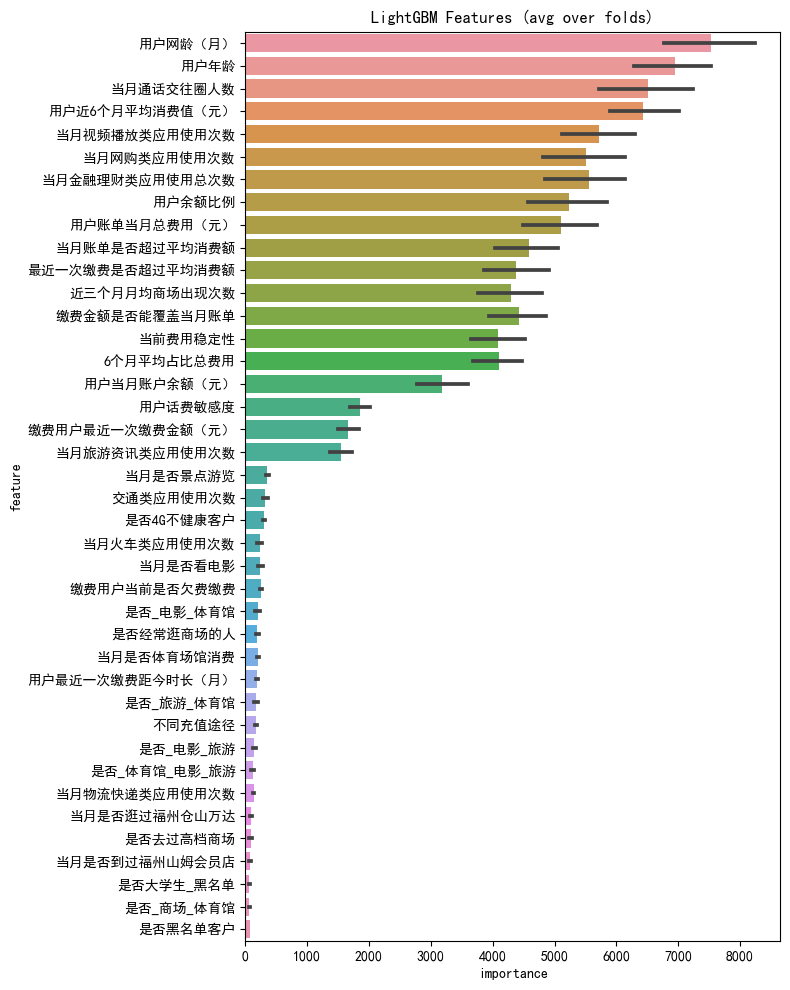

In [30]:
display_importances(feature_importance_df)

# XGB训练及预测

In [31]:
#xgb
import xgboost as xgb
xgb_params={'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': True, 'nthread': 8}#xgb的参数
from sklearn.model_selection import KFold
cv_pred_allxgb=0
en_amount=3
oof_xgb1=np.zeros(len(train_data))#用于存放训练集的预测
prediction_xgb1=np.zeros(len(test_data))#用于存放测试集的预测
for seed in range(en_amount):
    NFOLDS=5
    train_label=train_data['信用分']
    kfold=KFold(n_splits=NFOLDS, shuffle=True, random_state=seed+2019)
    kf=kfold.split(train_data,train_label)
    
    train_data_use = train_data.drop(['用户编码','信用分'], axis=1)
    test_data_use = test_data.drop(['用户编码'], axis=1)
    
    cv_pred = np.zeros(test_data.shape[0])
    valid_best_l2_all = 0
    
    feature_importance_df = pd.DataFrame()
    count = 0
    
    for i, (train_fold, validate) in enumerate(kf):
        print('fold: ',i, ' training')
        X_train, X_validate, label_train, label_validate = train_data_use.iloc[train_fold, :], train_data_use.iloc[validate, :], train_label[train_fold], train_label[validate]
        dtrain = xgb.DMatrix(X_train, label_train)#训练集的80%
        dvalid = xgb.DMatrix(X_validate, label_validate)#训练集的20%，验证集

        watchlist = [(dtrain, 'train'), (dvalid, 'valid_data')]
        bst = xgb.train(dtrain=dtrain, num_boost_round=10000, evals=watchlist, early_stopping_rounds=100, verbose_eval=300, params=xgb_params)#80%用于训练过程
        cv_pred += bst.predict(xgb.DMatrix(test_data_use), ntree_limit=bst.best_ntree_limit)
        oof_xgb1[validate]=bst.predict(xgb.DMatrix(X_validate),ntree_limit=bst.best_ntree_limit)#预测20%的验证集
        prediction_xgb1+=bst.predict(xgb.DMatrix(test_data_use),ntree_limit=bst.best_ntree_limit)/kfold.n_splits#预测测试集，并且取平均
        count += 1
        
    cv_pred /= NFOLDS
    cv_pred_allxgb+=cv_pred
cv_pred_allxgb /= en_amount


fold:  0  training


XGBoostError: [23:29:11] C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/data/data.cc:1104: Check failed: valid: Input data contains `inf` or `nan`

In [32]:
prediction_xgb1/=en_amount

In [33]:
#逻辑回归LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb1,oof_xgb1]).transpose()
test_stack = np.vstack([prediction_lgb1, prediction_xgb1]).transpose()
#贝叶斯分类器也使用交叉验证的方法，5折，重复2次，主要是避免过拟合
folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2019)
oof_stack = np.zeros(train_stack.shape[0])#存放训练集中验证集的预测结果
predictions = np.zeros(test_stack.shape[0])#存放测试集的预测结果
target=train_data['信用分']
#enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，一般用在 for 循环当中。
for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):#target就是每一行样本的标签值
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values#划分训练集的80%
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values#划分训练集的20%做验证集

    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)#贝叶斯训练过程，sklearn中的。
    
    oof_stack[val_idx] = clf_3.predict(val_data)#对验证集有一个预测，用于后面计算模型的偏差
    predictions += clf_3.predict(test_stack) / 10#对测试集的预测，除以10是因为5折交叉验证重复了2次
    
mean_absolute_error(target.values, oof_stack)#计算出模型在训练集上的均方误差

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


14.705992082489084

In [34]:
test_data_sub1 = test_data[['用户编码']]
test_data_sub1['score'] =  predictions
test_data_sub1.columns = ['id','score']
test_data_sub1['score1'] = cv_pred_all


C:\Users\86182\AppData\Local\Temp\ipykernel_1432\4286160499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_sub1['score'] =  predictions
C:\Users\86182\AppData\Local\Temp\ipykernel_1432\4286160499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_sub1['score1'] = cv_pred_all


In [35]:
test_data_sub1['score'] = test_data_sub1['score'].apply(lambda x: int(np.round(x)))

C:\Users\86182\AppData\Local\Temp\ipykernel_1432\1534940943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_sub1['score'] = test_data_sub1['score'].apply(lambda x: int(np.round(x)))


In [36]:
test_data_sub1.head()

id  score      score1
0  7171737d49b143d1b38883a39e4a5730    600  602.019490
1  3af0a449d5424488912e8fb2bf4b9faa    529  531.812935
2  eb2cf02e0d5c4d1294dd73e776dbb441    671  671.510521
3  9c0f780ecb254670a11aa9e3f10777c5    674  674.557039
4  d794eed46c1e44f785a575f18b3023a5    657  658.080783

In [37]:
test_data_sub1[['id','score']].to_csv('./output/sub2_28.csv', index=False)